In [1]:
import numpy as np

discreteness = 20
learning_rate = 0.2
iterations = 10000
action_randomness = 0.5
action_randomness_decay_rate = (1 - action_randomness) / iterations
discount_factor = 0.99
render_period = 1000
env_name = 'MountainCar-v0'

In [2]:
def make_discrete(env, observation):
    discrete = []
    for low, high, value in zip(env.observation_space.low, env.observation_space.high, observation):
        discrete.append(int((value - low) / (high - low) * discreteness))
    return discrete

In [3]:
import random

q_table = None
def create_q_table(env):
    global q_table
    # env.action_space.shape
    # np.append(env.observation_space.shape, env.action_space.n)
    q_table_shape = [discreteness for i in range(env.observation_space.shape[0])]
    q_table_shape.append(env.action_space.n)
    q_table = np.zeros(q_table_shape)

def get_action(env, state):
    global action_randomness
    
    action_randomness -= action_randomness_decay_rate
    action = 0
    if random.random() > action_randomness:
        state_discrete = make_discrete(env, state)
        action = q_table[tuple(state_discrete)].argmax()
    else:
        action = random.randint(0, env.action_space.n - 1)
    return action
    
def get_action2(env, state):
    position = state[0]
    velocity = state[1]
    
    if min(-0.09*(position + 0.25)**2 + 0.03, 0.3*(position + 0.9)**4 - 0.008 <= velocity <= -0.07*(position + 0.38)**2 + 0.07):
        action = 2
    else:
        action = 0
    return action
    
def update_q_table(env, state_old, action, state_new, reward):
    state_old_discrete = make_discrete(env, state_old)
    state_new_discrete = make_discrete(env, state_new)
    #print(state_old_discrete)
    q_table[tuple(state_old_discrete + [action])] = (1 - learning_rate) * q_table[tuple(state_old_discrete + [action])] \
                                + learning_rate * (reward + discount_factor * q_table[tuple(state_new_discrete)].max())

In [4]:
import gym
env = gym.make(env_name)
print(env.observation_space.low)
print(env.observation_space.high)

[-1.2  -0.07]
[0.6  0.07]


In [5]:
import gym
from tqdm import tqdm_notebook

env = gym.make(env_name)
create_q_table(env)
observation = env.reset()

record = env.spec.max_episode_steps - 1
history = []

for i in tqdm_notebook(range(iterations)):
    observation = env.reset()
    done = False
    reward_sum = 0
    for j in range(env.spec.max_episode_steps):
        if i % render_period == 0:
            env.render(mode='rgb_array')
        
        observation_old = observation
        action = get_action(env, observation)
        observation, reward, done, info = env.step(action)
        reward_sum += reward

        update_q_table(env, observation_old, action, observation, reward)
        
        if done == True:
            history.append(reward_sum)
            if j < record:
                print(f'New high score: {j} steps on {i} iteration')
                record = j
            break
            
env.close()

New high score: 196 steps on 308 iteration
New high score: 170 steps on 352 iteration
New high score: 161 steps on 353 iteration
New high score: 158 steps on 528 iteration
New high score: 154 steps on 533 iteration
New high score: 153 steps on 598 iteration
New high score: 151 steps on 765 iteration
New high score: 150 steps on 830 iteration
New high score: 149 steps on 860 iteration
New high score: 143 steps on 868 iteration
New high score: 142 steps on 888 iteration
New high score: 117 steps on 1424 iteration
New high score: 113 steps on 1437 iteration
New high score: 112 steps on 2174 iteration
New high score: 111 steps on 2178 iteration
New high score: 110 steps on 2211 iteration
New high score: 109 steps on 2219 iteration
New high score: 108 steps on 2223 iteration



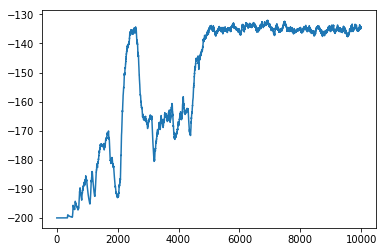

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.99):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(np.arange(len(history)), smoothen_curve(history))

In [7]:
import time

env = gym.make(env_name)
observation = env.reset()

for i in range(iterations):
    observation = env.reset()
    done = False
    for j in range(env.spec.max_episode_steps):
        env.render()
        #time.sleep(0.1)
        
        action = get_action(env, observation)
        observation, reward, done, info = env.step(action)
        
        if done == True:
            if j < env.spec.max_episode_steps - 1:
                print(f'Win {j} steps on {i} iteration')
            break
env.close()

Win 115 steps on 0 iteration


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


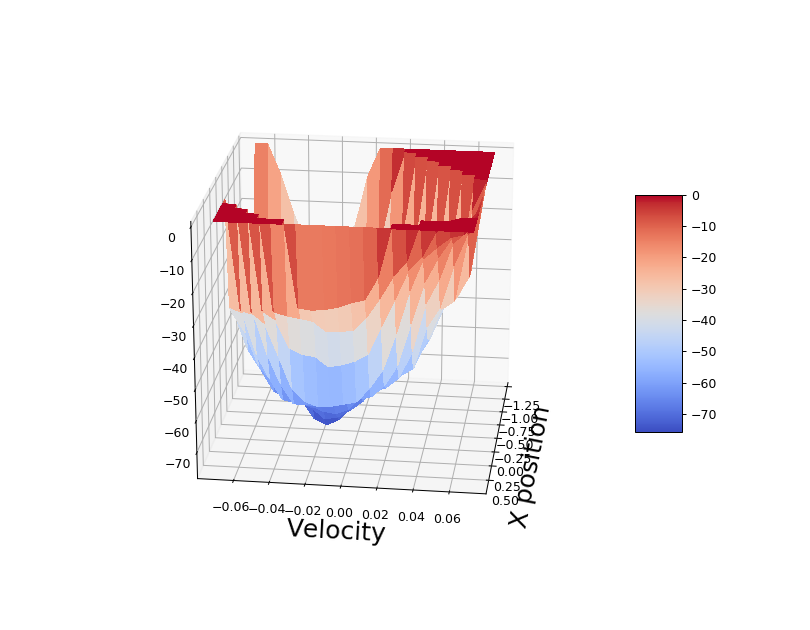

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
%matplotlib notebook

fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')


# Make data
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], q_table.shape[0])
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], q_table.shape[1])
z = np.min(q_table, axis=-1)


# Make data.
X, Y = np.meshgrid(x, y)

# Plot the surface.
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('X position', fontsize=20)
ax.set_ylabel('Velocity', fontsize=20)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
